## Preparation of Dataset

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"
%cd /content/drive/My Drive/Kaggle

/content/drive/My Drive/Kaggle


In [ ]:
!wget http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz


--2020-06-12 22:52:52--  http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1150585339 (1.1G) [application/x-tar]
Saving to: ‘CUB_200_2011.tgz’

CUB_200_2011.tgz    100%[===================>]   1.07G  6.85MB/s    in 1m 50s  

2020-06-12 22:54:42 (9.97 MB/s) - ‘CUB_200_2011.tgz’ saved [1150585339/1150585339]



In [ ]:
!ls

CUB_200_2011.tgz  kaggle.json


In [ ]:
!tar -xvf '/content/drive/My Drive/Kaggle/CUB_200_2011.tgz'

In [ ]:
import tarfile
tar=tarfile.open('/content/drive/My Drive/Kaggle/CUB_200_2011.tgz')
tar.extractall()
tar.close()

In [ ]:
cd CUB_200_2011

/content/drive/My Drive/Kaggle/CUB_200_2011


In [ ]:
!ls

attributes	    image_class_labels.txt  parts
bounding_boxes.txt  images		    README
classes.txt	    images.txt		    train_test_split.txt


# Loading the Dataset

In [ ]:
def laod_class_ids(class_info_file_path):
    """ load class ids from class_info.pickle file"""
    with open(class_info_file_path,'rb') as f:
        class_ids=pickle.load(f,encoding='latin1')
        return class_ids

In [ ]:
def load_embeddings(embeddings_file_path):
    """ Load embeddings """
    with open(embeddings_file_path,'rb') as f:
        embeddings=pickle.load(f,encoding='latin1')
        embeddings=np.asarray(embeddings)
        print('embeddings: ',embeddings.shape)
    return embeddings

In [ ]:
def load_filenames(filenames_file_path):
    """ Load filenames.pickle & return list of all file names"""
    with open(filenames_file_path,'rb') as f:
        filenames=pickle.load(f,encoding='latin1')
    return filenames

In [ ]:
def load_bounding_boxes(dataset_dir):
    """ Load bounding boxes and return a dictionary of file names and corresponding bbox"""
    #Paths
    bounding_boxes_path=os.path.join(dataset_dir,'bounding_boxes.txt')
    file_paths_path = os.path.join(dataset_dir,'images.txt')

    #read bounding boxes.txt and images.txt
    df_bounding_boxes=pd.read_csv(bounding_boxes_path,delim_whitespace=True,header=None).astype(int)
    df_file_names=pd.read_csv(file_paths_path,delim_whitespace=True,header=None)

    #create a list of file names
    file_names=df_file_names[1].tolist()

    #create a dictionary of file names and bounding boxes
    filename_boundingbox_dict={img_file[:-4]:[] for img_file in file_names[:2]}

    #Assign a bounding box to the corresponding image
    for i in range(0,len(file_names)):
        #get the bounding box
        bounding_box=df_bounding_boxes.iloc[i][1:].tolist()
        key=file_names[i][:-4]
        filename_boundingbox_dict[key]= bounding_box
    return filename_boundingbox_dict

In [ ]:
def get_img(img_path,bbox,image_size):
    """ Load and resize img"""
    img=Image.open(img_path).convert('RGB')
    width,height = img.size
    if bbox is not None:
        R=int(np.maximum[bbox[2],bbox[3]*0.75])
        center_x=int((2*bbox[0] + bbox[2]) / 2)
        center_y=int((2*bbox[1]+ bbox[3]) / 2)
        y1=np.maximum(0,center_y - R)
        y2=np.minimum(height,center_y + R)
        x1=np.maximum(0,center_x - R)
        x2=np.minimum(width,center_X + R)
        img=img.crop([x1,y1,x2,y2])
    img = img.resize(image_size,PIL.Image.BILINEAR)
    return img

In [ ]:
def load_dataset(filenames_file_path,class_info_file_path,cub_dataset_dir,embeddings_file_path,image_size):
    filenames=load_filenames(filenames_file_path)
    class_ids=laod_class_ids(class_info_file_path)
    bounding_boxes=load_bounding_boxes(cub_dataset_dir)
    all_embeddings=load_embeddings(embeddings_file_path)

    X,y,embeddings= [],[],[]

    print("Embeddings shape:",all_embeddings.shape)

    for index,filename in enumerate(filename):
        bounding_box=bounding_boxes[filename]

        try:
            #Load images
            img_name='{}/images/{}.jpg'.format(cub_dataset_dir,filename)
            img=get_img(img_name,bounding_box,image_size)

            all_embeddings1=all_embeddings[index, :, :]

            embedding_ix= random.randint(0,all_embeddings1.shape[0]-1)
            embedding= all_embeddings1[embedding_ix,:]

            X.append(np.array(img))
            y.append(class_ids[index])
            embeddings.append(embedding)
        except Exception as e:
            print(e)

    X=np.array(X)
    y=np.array(y)
    embeddings=np.array(embeddings)
    return X,y,embeddings




# Layout

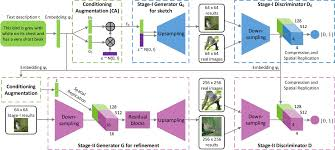

**Embedding:** Converts the input variable length text into a fixed length vector. we will be using a pre-trained character level embedding.

**Conditioning Augmentation (CA)**

**Stage I Generator:** Generates low resolution (64*64) images.

**Stage I Discriminator**

**Residual Blocks**

**Stage II Generator:** Generates high resolution (256*256) images.

**Stage II Discriminator**

# Implementation of Stage I of StackGAN


In [ ]:
import os
import pickle
import random
import time

import PIL
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from keras import Input, Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.layers import Dense, LeakyReLU, BatchNormalization, ReLU, Reshape, UpSampling2D, Conv2D, Activation, \
    concatenate, Flatten, Lambda, Concatenate
from keras.optimizers import Adam
from matplotlib import pyplot as plt

### Architecture

In [ ]:
# C= stddev X epsilon + mean
def generate_c(x):
    mean= x[:,:128]
    log_sigma=x[:,128:]
    stddev=K.exp(log_sigma)
    epsilon=K.random_normal(shape=K.constant((mean.shape[1],),dtype='int32'))
    c=stddev*epsilon + mean
    return c

In [ ]:
# Conditioning Augmentation model
def build_ca_model():
    """ Takes embeding of shape (1024,) and returns a tensor of shape (256,)"""
    input_layer=Input(shape=(1024,))
    x=Dense(256)(input_layer)
    x=LeakyReLU(alpha=0.2)(x)
    model=Model(inputs=[input_layer],outputs=[x])
    model.compile(loss='binary_crossentropy',optimizer='adam')
    return model

In [ ]:
# embedding compressor model():
def build_embedding_compressor_model():
    """Takes embeding of shape (1024,) and returns a tensor of shape (128,)"""
    input_layer=Input(shape=(1024,))
    x=Dense(128)(input_layer)
    x=ReLU()(x)
    model=Model(inputs=[input_layer],outputs=[x])
    model.compile(loss='binary_crossentropy',optimizer='adam')
    return model

In [ ]:
# generator model used in Stage-I
def build_stage1_generator():
    #embedding input
    input_layer=Input(shape=(1024,))
    x=Dense(256)(input_layer)
    mean_logsigma=LeakyReLU(alpha=0.2)(x)
    # generate_c
    c=Lambda(generate_c)(mean_logsigma)

    input_layer2=Input(shape=(100,))

    gen_input=Concatenate(axis=1)([c,input_layer2])

    x=Dense(128*8*4*4, use_bias=False)(gen_input)
    x=ReLU()(x)

    x=Reshape((4,4,128*8),input_shape=(128*8*4*4,))(x)

    x=UpSampling2D(size=(2,2))(x)
    x=Conv2D(512,kernel_size=3,padding="same",strides=1,use_bias=False)(x)
    x=BatchNormalization()(x)
    x=ReLU()(x)

    x=UpSampling2D(size=(2,2))(x)
    x=Conv2D(256,kernel_size=3,padding="same",strides=1,use_bias=False)(x)
    x=BatchNormalization()(x)
    x=ReLU()(x)

    x=UpSampling2D(size=(2,2))(x)
    x=Conv2D(128,kernel_size=3,padding="same",strides=1,use_bias=False)(x)
    x=BatchNormalization()(x)
    x=ReLU()(x)

    x=UpSampling2D(size=(2,2))(x)
    x=Conv2D(64,kernel_size=3,padding="same",strides=1,use_bias=False)(x)
    x=BatchNormalization()(x)
    x=ReLU()(x)

    x=Conv2D(3,kernel_size=3,padding="same",strides=1,use_bias=False)(x)
    x=Activation(activation='tanh')(x)

    stage1_gen= Model(inputs=[input_layer,input_layer2],outputs=[x,mean_logsigma]) 
    return stage1_gen

In [ ]:
# discriminator model used in stage-I
def build_stage1_discriminator():

    """ model takes two inputs: (i) from above network (ii) from embedding layer 
        model concatenate along the axis dimension and feed it to the last module which produces final thoughts"""
    input_layer= Input(shape=(64,64,3))

    x=Conv2D(64,(4,4),padding='same',strides=2,input_shape=(64,64,3),use_bias=False)(input_layer)
    x=LeakyReLU(alpha=0.2)(x)

    x=Conv2D(128,(4,4),padding='same',strides=2,use_bias=False)(x)
    x=BatchNormalization()(x)
    x=LeakyReLU(alpha=0.2)(x)

    x=Conv2D(256,(4,4),padding='same',strides=2,use_bias=False)(x)
    x=BatchNormalization()(x)
    x=LeakyReLU(alpha=0.2)(x)

    x=Conv2D(512,(4,4),padding='same',strides=2,use_bias=False)(x)
    x=BatchNormalization()(x)
    x=LeakyReLU(alpha=0.2)(x)
        
    input_layer2=Input(shape=(4,4,128))

    merged_input=concatenate([x,input_layer2])

    x2=Conv2D(64*8, kernel_size=1, padding='same',strides=1)(merged_input)
    x2=BatchNormalization()(x2)
    x2=LeakyReLU(alpha=0.2)(x2)
    x2=Flatten()(x2)
    x2=Dense(1)(x2)
    x2=Activation('sigmoid')(x2)

    stage1_dis=Model(inputs=[input_layer,input_layer2],outputs=[x2])
    return stage1_dis

In [ ]:
# adversial network
def build_adversial_model(gen_model,dis_model):
    input_layer=Input(shape=(1024,))
    input_layer2=Input(shape=(100,))
    input_layer3=Input(shape=(4,4,128))

    x,mean_logsigma=gen_model([input_layer,input_layer2])

    dis_model.trainable=False
    valid=dis_model([x,input_layer3])

    model=Model(inputs=[input_layer,input_layer2,input_layer3],outputs=[valid,mean_logsigma])
    return model

### Defining loss

In [ ]:
def KL_loss(y_true,y_pred):
    mean=y_pred[:,:128]
    logsigma=y_pred[:,:128]
    loss= -logsigma + .5* (-1 + K.exp(2 * logsigma) +K.square(mean))
    loss=K.mean(loss)
    return loss

In [ ]:
def custom_generator_loss(y_true,y_pred):
    return K.binary_crossentropy(y_true,y_pred)

In [ ]:
def write_log(callback,name,loss,batch_no):
    summary=tf.Summary()
    summary_value = sumamry.value.add()
    summary_value.simple_value = loss
    summary_value.tag = name
    callback.writer.add_summary(summary,batch_no)
    callback.writer.flush()


In [ ]:
def save_rgb_image(img,path):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title("Image")

    plt.savefig(path)
    plt.close()

### Train

In [ ]:
if __name__=='__main__':
    image_size=64
    batch_size=64
    z_dim=100
    stage1_generator_lr=0.0002
    stage1_discriminator_lr=0.0002
    stage1_lr_decay_step=600
    epochs=100
    condition_dim=128

    data_dir=''
    train_dir=''
    test_dir=''
    embeddings_file_path_train= train_dir + ''
    embeddings_file_path_test= train_dir + ''
    filenames_file_path_train=train_dir + ''
    filenames_file_path_test=train_dir + ''
    cub_dataset_dir=''

    dis_optimizer=Adam(lr=stage1_discriminator_lr,beta_1=0.5,beta_2=0.999)
    gen_optimizer=Adam(lr=stage1_generator_lr,beta_1=0.5,beta_2=0.999)

    #load datasets
    X_train,y_train,embeddings_train= load_dataset(filenames_file_path=filenames_file_path_train,class_info_file_path=class_info_file_path_train,cub_dataset_dir=cub_dataset_dir,embeddings_file_path=embeddings_file_path_train,image_size=(64,64))
    X_test,y_test,embeddings_test= load_dataset(filenames_file_path=filenames_file_path_test,class_info_file_path=class_info_file_path_test,cub_dataset_dir=cub_dataset_dir,embeddings_file_path=embeddings_file_path_test,image_size=(64,64))

    #Build and compile networks
    ca_model=build_ca_model()
    
    stage1_dis=build_stage1_discriminator()
    stage1_dis.compile(loss='binary_crossentropy', optimizer=dis_optimizer)

    stage1_gen=build_stage1_generator()
    stage1_gen.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

    embedding_compressor_model=build_embedding_compressor_model()

    adversial_model= build_adversial_model(gen_model=stage1_gen,dis_model=stage1_dis)
    adversial_model.compile(loss=['binary_crossentropy',KL_loss],loss_weights=[1,2.0],optimizer=gen_optimizer,metrics=None)

    #tensorboard logs
    tensorboard = TensorBoard(log_dir="logs/".format(time.time()))
    tensorboard.set_model(stage1_gen)
    tensorboard.set_model(stage1_dis)
    tensorboard.set_model(ca_model)
    tensorboard.set_model(embedding_compressor_model)

    #Generate an array containing real and fake values and label smoothning
    real_labels=np.ones((batch_size,1),dtype=float) * 0.9
    fake_labels=np.zeros((batch_size,1),dtype=float) * 0.1

    #enumerate on no.of epochs
    for epoch in range(epochs):
        print("..................................")
        print("Epoch is:",epoch)
        print("No.of batches",int(X_train.shape[0]/batch_size))

        gen_losses= []
        dis_losses= []

        #load data and train model
        number_of_batches= int(X_train.shape[0]/batch_size)
        for index in range(number_of_batches):
            print("Batch:{}".format(index+1))

            """
            Train the discriminator network
            """

            #sample a batch of data
            z_noise=np.random.normal(0,1,size=(batch_size,z_dim))
            image_batch=X_train[index * batch_size:(index+1)*batch_size]
            embedding_batch=embeddings_train[index*batch_size:(index+1)*batch_size] 
            image_batch=(image_batch-127.5)/127.5

            #generate fake images
            fake_images,_=stage1_gen.predict([embedding_batch,z_noise],verbose=3)

            #generate compressed embeddings
            compressed_embedding=embedding_compressor_model.predict_on_batch(embedding_batch)
            compressed_embedding=np.reshape(compressed_embedding,(-1,1,1,condition_dim))
            compressed_embedding=np.tile(compressed_embedding,(1,4,4,1))

            #training 
            dis_loss_real=stage1_dis.train_on_batch([image_batch,compressed_embedding],np.reshape(real_labels,(batch_size,1)))
            dis_loss_fake=stage1_dis.train_on_batch([fake_images,compressed_embedding],np.reshape(fake_labels,(batch_size,1)))
            dis_loss_wrong=stage1_dis.train_on_batch([image_batch[:(batch_size-1)],compressed_embedding[1:]],np.reshape(fake_labels[1:],(batch_size-1,1)))

            d_loss=0.5 *np.add(dis_loss_real,0.5 *np.add(dis_loss_wrong,dis_loss_fake))

            print("d_loss_real:{}".format(dis_loss_real))
            print("d_loss_fake:{}".format(dis_loss_fake))
            print("d_loss_wrong:{}".format(dis_loss_wrong))
            print("d_loss:{}".format(d_loss))

            """
            Train the generator network
            """

            g_loss=adversial_model.train_on_batch([embedding_batch,z_noise,compressed_embedding],[K.ones((batch_size,1))*0.9,K.ones((batch_size,256))*0.9])
            print("g_loss:{}".format(g_loss))

            #saving the loses
            dis_losses.append(d_loss)
            gen_losses.append(g_loss)

            """
            Save losses to tensorboard
            """
            write_log(tensorboard,'discriminator_loss',np.mean(dis_losses),epoch)
            write_log(tensorboard,'generator_loss',np.mean(gen_losses[0]),epoch)

            #generate and save images after every 2 epochs
            if epoch%2==0:
                z_noise2=np.random.normal(0,1,size=(batch_size,z_dim))
                embedding_batch=embeddings_test[0:batch_size]
                fake_images,_=stage1_gen.predict_on_batch([embedding_batch,z_noise2])

                for i,img in enumerate(fake_images[:10]):
                    save_rgb_image(img,"results/gen_{}_{}.png".format(epoch,i))

        #save models
        stage1_gen.save_weights("stage1_gen.h5")
        stage1_dis.save_weights("stage1_dis.h5")




NameError: ignored

# Implementation of Stage II of StackGAN


###Architecture

In [ ]:
# def build_ca_model()
# def build_embedding_compressor_model()
# def generate_c(x)
# def build_stage1_generator() 

In [1]:
def residual_block(input):
    """
    Residual block in the generator network
    """
    x=Conv2D(128*4,kernel_size=(3,3),padding='same',strides=1)(input)
    x=BatchNormalization()(x)
    x=ReLU()(x)

    x=Conv2D(128*4,kernel_size=(3,3),strides=1,padding='same')(x)
    x=BatchNormalization()(x)

    x=Add([x,input])
    x=ReLU()(x)

    return x

In [2]:
def joint_block(inputs):
    c=inputs[0]
    x=inputs[1]

    c=K.expand_dims(c,axis=1)
    c=K.expand_dims(c,axis=1)
    c=K.tile(c,[1,16,16,1])
    return K.concatenate([c,x],axis=3)

In [3]:
def build_stage2_generator():
    """
    Create stage-II generator containing the CA Augmentation Network, the image encoder and the generator network
    """

    #1. CA Augmentation Network
    input_layer= Input(shape=(1024,))
    input_lr_images= Input(shape=(64,64,3))

    ca= Dense(256)(input_layer)
    mean_ligsigma=LeakyReLU(alpha=0.2)(ca)
    c= Lambda(generate_c)(mean_logsigma)

    #2. Image Encoder
    x=ZeroPadding2D(padding=(1,1))(input_lr_images)
    x=Conv2D(128,kernel_size=(3,3),strides=1,use_bias=False)(x)
    x=ReLU()(x)

    x=ZeroPadding2D(padding=(1,1))(x)
    x=Conv2D(256,kernel_size=(4,4),strides=2,use_bias=False)(x)
    x=BatchNormalization()(x)
    x=ReLU()(x)

    x=ZeroPadding2D(padding=(1,1))(x)
    x=Conv2D(512,kernel_size=(4,4),strides=2,use_bias=False)(x)
    x=BatchNormalization()(x)
    x=ReLU()(x)

    #3. Joint
    c_code = Lambda(joint_block)([c,x])

    x=ZeroPadding2D(padding=(1,1))(c_code)
    x=Conv2D(512,kernel_size=(3,3),strides=1,use_bias=False)(x)
    x=BatchNormalization()(x)
    x=ReLU()(x)

    #4. Residual Blocks
    for _ in range(4):
        x=residual_block(x)

    #5. Upsampling blocks
    x=Upsampling2D(size=(2,2))(x)
    x=Conv2D(512,kernel_size=3,padding='same',strides=1,use_bias=False)(x)
    x=BatchNormalization()(x)
    x=ReLU()(x)

    x=Upsampling2D(size=(2,2))(x)
    x=Conv2D(256,kernel_size=3,padding='same',strides=1,use_bias=False)(x)
    x=BatchNormalization()(x)
    x=ReLU()(x)

    x=Upsampling2D(size=(2,2))(x)
    x=Conv2D(128,kernel_size=3,padding='same',strides=1,use_bias=False)(x)
    x=BatchNormalization()(x)
    x=ReLU()(x)

    x=Upsampling2D(size=(2,2))(x)
    x=Conv2D(64,kernel_size=3,padding='same',strides=1,use_bias=False)(x)
    x=BatchNormalization()(x)
    x=ReLU()(x)
    
    x=Conv2D(3,kernel_size=3,padding='same',strides=1,use_bias=False)(x)
    x=Activation('tanh')(x)
    
    model= Model(inputs=[input_layer,input_lr_images],outputs=[x,mean_logsigma])
    return model

In [4]:
def build_stage2_discriminator():
    """
    Create Stage-II discriminator network
    """
    input_layer= Input(shape=(256,256,3))

    x=Conv2D(64,(4,4),padding='same',strides=2,input_shape=(256,256,3),use_bias=False)(input_layer)
    x=LeakyReLU(alpha=0.2)(x)

    x=Conv2D(128,(4,4),padding='same',strides=2,use_bias=False)(x)
    x=BatchNormalization()(x)
    x=LeakyReLU(alpha=0.2)(x)

    x=Conv2D(256,(4,4),padding='same',strides=2,use_bias=False)(x)
    x=BatchNormalization()(x)
    x=LeakyReLU(alpha=0.2)(x)

    x=Conv2D(512,(4,4),padding='same',strides=2,use_bias=False)(x)
    x=BatchNormalization()(x)
    x=LeakyReLU(alpha=0.2)(x)

    x=Conv2D(1024,(4,4),padding='same',strides=2,use_bias=False)(x)
    x=BatchNormalization()(x)
    x=LeakyReLU(alpha=0.2)(x)

    x=Conv2D(2048,(4,4),padding='same',strides=2,use_bias=False)(x)
    x=BatchNormalization()(x)
    x=LeakyReLU(alpha=0.2)(x)

    x=Conv2D(1024,(1,1),padding='same',strides=1,use_bias=False)(x)
    x=BatchNormalization()(x)
    x=LeakyReLU(alpha=0.2)(x)

    x=Conv2D(512,(1,1),padding='same',strides=1,use_bias=False)(x)
    x=BatchNormalization()(x)
    
    x2=Conv2D(128,(1,1),padding='same',strides=1,use_bias=False)(x)
    x2=BatchNormalization()(x2)
    x2=LeakyReLU(alpha=0.2)(x2)

    x2=Conv2D(128,(3,3),padding='same',strides=1,use_bias=False)(x2)
    x2=BatchNormalization()(x2)
    x2=LeakyReLU(alpha=0.2)(x2)

    x2=Conv2D(512,(3,3),padding='same',strides=1,use_bias=False)(x2)
    x2=BatchNormalization()(x2)

    added_x=add([x,x2])
    added_x=LeakyReLU(alpha=0.2)(added_x)

    input_layer2=Input(shape=(4,4,128))

    merged_input= concatenate([added_x, input_layer2])

    x3=Conv2D(64*8,kernel_size=1, padding="same",strides=1)(merged_input)
    x3=BatchNormalization()(x3)
    x3=LeakyReLU(alpha=0.2)(x3)
    x3=Flatten()(x3)
    x3=Dense(1)(x3)
    x3=Activation('sigmoid')(x3)

    stage2_dis= Model(inputs=[input_layer,input_layer2],outputs=[x3])
    return stage2_dis



In [6]:
#adversial for stageII
def build_adversial_model(gen_model2,dis_model,gen_model1):
    embeddings_input_layer= Input(shape=(1024,))
    noise_input_layer= Input(shape=(100,))
    compressed_embedding_input_layer= Input(shape=(4,4,128))

    gen_model1.trainable= False
    dis_model.trainable= False

    lr_images, mean_logsigma1= gen_model1([embeddings_input_layer,noise_input_layer])
    hr_images, mean_logsigma2= gen_model2([embeddings_input_layer,lr_images])
    valid= dis_model([hr_images,compressed_embedding_input_layer])

    model=Model(inputs=[embeddings_input_layer,noise_input_layer,compressed_embedding_input_layer],outputs=[valid,mean_logsigma2])
    return model


### Train

In [ ]:
if __name__=='__main__':
    hr_image_size=(256,256)
    lr_image_size=(64,64)
    batch_size=32
    z_dim=100
    stage1_generator_lr=0.0002
    stage1_discriminator_lr=0.0002
    stage1_lr_decay_step=600
    epochs=5
    condition_dim=128

    data_dir=''
    train_dir=''
    test_dir=''
    embeddings_file_path_train= train_dir + ''
    embeddings_file_path_test= train_dir + ''
    filenames_file_path_train=train_dir + ''
    filenames_file_path_test=train_dir + ''
    cub_dataset_dir=''

    dis_optimizer=Adam(lr=stage1_discriminator_lr,beta_1=0.5,beta_2=0.999)
    gen_optimizer=Adam(lr=stage1_generator_lr,beta_1=0.5,beta_2=0.999)

    #load datasets
    X_train,y_train,embeddings_train= load_dataset(filenames_file_path=filenames_file_path_train,class_info_file_path=class_info_file_path_train,cub_dataset_dir=cub_dataset_dir,embeddings_file_path=embeddings_file_path_train,image_size=(256,256))
    X_test,y_test,embeddings_test= load_dataset(filenames_file_path=filenames_file_path_test,class_info_file_path=class_info_file_path_test,cub_dataset_dir=cub_dataset_dir,embeddings_file_path=embeddings_file_path_test,image_size=(256,256))

    #Build and compile networks
    ca_model=build_ca_model()
    
    stage1_dis=build_stage1_discriminator()
    stage1_dis.compile(loss='binary_crossentropy', optimizer=dis_optimizer)

    stage1_gen=build_stage1_generator()
    stage1_gen.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

    embedding_compressor_model=build_embedding_compressor_model()

    adversial_model= build_adversial_model(gen_model=stage1_gen,dis_model=stage1_dis)
    adversial_model.compile(loss=['binary_crossentropy',KL_loss],loss_weights=[1,2.0],optimizer=gen_optimizer,metrics=None)

    #tensorboard logs
    tensorboard = TensorBoard(log_dir="logs/".format(time.time()))
    tensorboard.set_model(stage1_gen)
    tensorboard.set_model(stage1_dis)
    tensorboard.set_model(ca_model)
    tensorboard.set_model(embedding_compressor_model)

    #Generate an array containing real and fake values and label smoothning
    real_labels=np.ones((batch_size,1),dtype=float) * 0.9
    fake_labels=np.zeros((batch_size,1),dtype=float) * 0.1

    #enumerate on no.of epochs
    for epoch in range(epochs):
        print("..................................")
        print("Epoch is:",epoch)
        print("No.of batches",int(X_train.shape[0]/batch_size))

        gen_losses= []
        dis_losses= []

        #load data and train model
        number_of_batches= int(X_train.shape[0]/batch_size)
        for index in range(number_of_batches):
            print("Batch:{}".format(index+1))

            """
            Train the discriminator network
            """

            #sample a batch of data
            z_noise=np.random.normal(0,1,size=(batch_size,z_dim))
            image_batch=X_train[index * batch_size:(index+1)*batch_size]
            embedding_batch=embeddings_train[index*batch_size:(index+1)*batch_size] 
            image_batch=(image_batch-127.5)/127.5

            #generate fake images
            fake_images,_=stage1_gen.predict([embedding_batch,z_noise],verbose=3)

            #generate compressed embeddings
            compressed_embedding=embedding_compressor_model.predict_on_batch(embedding_batch)
            compressed_embedding=np.reshape(compressed_embedding,(-1,1,1,condition_dim))
            compressed_embedding=np.tile(compressed_embedding,(1,4,4,1))

            #training 
            dis_loss_real=stage1_dis.train_on_batch([image_batch,compressed_embedding],np.reshape(real_labels,(batch_size,1)))
            dis_loss_fake=stage1_dis.train_on_batch([fake_images,compressed_embedding],np.reshape(fake_labels,(batch_size,1)))
            dis_loss_wrong=stage1_dis.train_on_batch([image_batch[:(batch_size-1)],compressed_embedding[1:]],np.reshape(fake_labels[1:],(batch_size-1,1)))

            d_loss=0.5 *np.add(dis_loss_real,0.5 *np.add(dis_loss_wrong,dis_loss_fake))

            print("d_loss_real:{}".format(dis_loss_real))
            print("d_loss_fake:{}".format(dis_loss_fake))
            print("d_loss_wrong:{}".format(dis_loss_wrong))
            print("d_loss:{}".format(d_loss))

            """
            Train the generator network
            """

            g_loss=adversial_model.train_on_batch([embedding_batch,z_noise,compressed_embedding],[K.ones((batch_size,1))*0.9,K.ones((batch_size,256))*0.9])
            print("g_loss:{}".format(g_loss))

            #saving the loses
            dis_losses.append(d_loss)
            gen_losses.append(g_loss)

            """
            Save losses to tensorboard
            """
            write_log(tensorboard,'discriminator_loss',np.mean(dis_losses),epoch)
            write_log(tensorboard,'generator_loss',np.mean(gen_losses[0]),epoch)

            #generate and save images after every 2 epochs
            if epoch%2==0:
                z_noise2=np.random.normal(0,1,size=(batch_size,z_dim))
                embedding_batch=embeddings_test[0:batch_size]
                fake_images,_=stage1_gen.predict_on_batch([embedding_batch,z_noise2])

                for i,img in enumerate(fake_images[:10]):
                    save_rgb_image(img,"results/gen_{}_{}.png".format(epoch,i))

        #save models
        stage1_gen.save_weights("stage1_gen.h5")
        stage1_dis.save_weights("stage1_dis.h5")


